# Programmatically creating a SALT finder chart

```{note}
You can find this tutorial in the folder ``docs/notebooks`` in imephu's repository.
```

While having a command line interface (``imephu``) is helpful, there are use cases where you would rather create the finder chart in a Python script. For example, you might have a pipeline which is triggered by some event, creates the finder chart for it, assembles a block and then submits it.

Let's see how to achieve the part of creating the finder chart. We assume that we can use the UKSTU/POSS2 Red image survey and need a finder chart for an NIR observation. The first step is to collect all the necessary information.

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from imephu.salt.finder_chart import GeneralProperties, MagnitudeRange, Target

position = SkyCoord(ra="15h 49m 49.5s", dec="−29° 23′ 13″")
survey = "POSS2/UKSTU Red"
general_properties = GeneralProperties(
    target=Target(
        name="NGC 6000",
        position=position,
        magnitude_range=MagnitudeRange(
            bandpass="V",
            min_magnitude=11.3,
            max_magnitude=11.3
        )
    ),
    position_angle=0 * u.deg,
    automated_position_angle=False,
    proposal_code="2022-1-SCI-042",
    pi_family_name="Doe",
    survey=survey
)

The second step is to get the FITS image. Conveniently, there is a function for this.

In [2]:
from imephu.service.survey import load_fits

fits = load_fits(survey=survey, fits_center=position, size=10 * u.arcmin)

Creating the finder chart now is straightforward.

In [3]:
from imephu.salt.finder_chart import nir_finder_chart

finder_chart = nir_finder_chart(fits=fits, general=general_properties, science_bundle_center=position, bundle_separation=50 * u.arcsec)


What does this finder chart look like? To find an answer we save it as a png image and show that image. (There is a simpler way if you just need to show the finder chart on the screen, as will be shown below.)

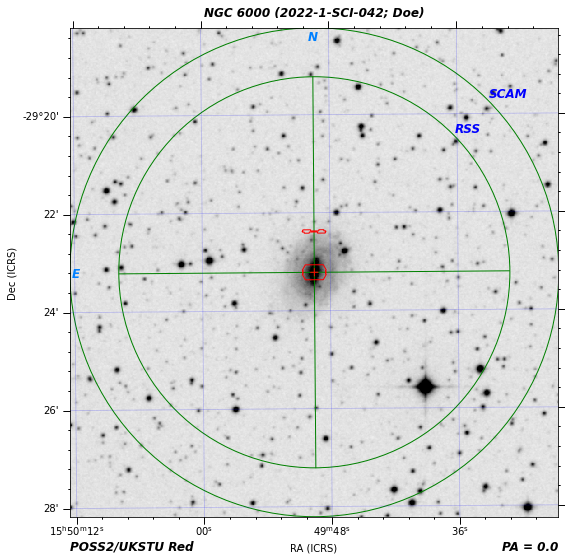

In [4]:
from io import BytesIO
from PIL import Image

image_content = BytesIO()
finder_chart.save(image_content)

image = Image.open(image_content)
image

Two quick notes might be appropriate here.

1. Instead of a ``~io.BytesIO`` you could pass a string or path-like object to save the finder chart in a file.
2. You can pass a format to the finder chart's ``save`` method to use a different image format, such as pdf.

So far we haven't gained much; the finder chart we have just created can automatically be created during a proposal submission anyway. But let's up the game and add some annotations to the chart. For simplicity, we'll just add a circle and some text.

In [5]:
from astropy.coordinates import Angle
from imephu.annotation.general import CircleAnnotation, TextAnnotation
from imephu.geometry import translate

wcs = finder_chart.wcs
circle = CircleAnnotation(
    center=position,
    radius=3 * u.arcmin,
    wcs=wcs,
    edgecolor="none",
    facecolor="green",
    alpha=0.2
)

text_position = translate(position, Angle([0 * u.arcmin, -3.2 * u.arcmin]))
text = TextAnnotation(
    position=text_position,
    s="NGC 6000 is in this circle",
    wcs=wcs,
    color="blue",
    fontsize=14
)

finder_chart.add_annotation(circle)
finder_chart.add_annotation(text)

Let's see whether this has worked as intended (and illustrate the promised simpler way of displaying a finder chart on the screen).

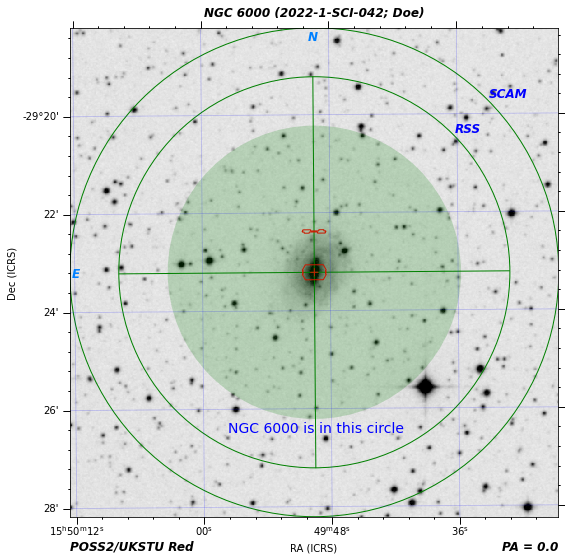

In [6]:
finder_chart.show()

Note that when creating an annotation you have to use the world coordinate system (WCS) for the finder chart, which is exposed as a property. The `translate` function moves a position by a given right ascension and declination. In this example we have used it to move the text by -3.2 arcminutes in declination.

